In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)


In [2]:
# Make sure to update the generate_pink_noise function to use TensorFlow operations as well
@tf.function
def generate_pink_noise(num_points):
    # Generate white noise
    white_noise = tf.random.normal([num_points])
    
    # Generate frequencies
    f = tf.range(1, num_points // 2 + 1, dtype=tf.float32)
    
    # Create 1/f spectrum
    spectrum = 1.0 / tf.sqrt(f)
    
    # Pad the spectrum for full FFT
    spectrum = tf.concat([tf.constant([1.0]), spectrum, tf.reverse(spectrum, [0])], 0)
    
    # Ensure spectrum has the same length as num_points
    if tf.shape(spectrum)[0] < num_points:
        spectrum = tf.pad(spectrum, [[0, num_points - tf.shape(spectrum)[0]]])
    else:
        spectrum = spectrum[:num_points]
    
    # Apply spectrum to white noise in frequency domain
    white_noise_fft = tf.signal.fft(tf.cast(white_noise, tf.complex64))
    pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
    
    # Inverse FFT to get back to time domain
    pink_noise = tf.math.real(tf.signal.ifft(pink_noise_fft))
    
    # Normalize
    pink_noise = pink_noise / tf.math.reduce_std(pink_noise)
    
    return pink_noise

In [14]:
@tf.function
def sim_channel(params):
    To, Tc, phase, Anoise, Fnoise = params
    
    # Generate random durations from the exponential distribution
    num_durations = 1000  # Number of durations to generate
    exp_dist_o = tfp.distributions.Exponential(rate=1.0 / To)
    exp_dist_c = tfp.distributions.Exponential(rate=1.0 / Tc)
    
    Odurations = exp_dist_o.sample(sample_shape=num_durations)
    Cdurations = exp_dist_c.sample(sample_shape=num_durations)
    
    # Initialize the sequence
    sequence = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    current_length = tf.constant(0, dtype=tf.int32)
    
    # Generate the sequence
    for i in tf.range(num_durations):
        # Open state
        duration = tf.cast(Odurations[i] // dt, tf.int32)
        open_values = tf.fill([duration], 0.5)
        sequence = sequence.write(i * 2, open_values)
        current_length += duration
        
        # Closed state
        duration = tf.cast(Cdurations[i] // dt, tf.int32)
        closed_values = tf.fill([duration], -0.5)
        sequence = sequence.write(i * 2 + 1, closed_values)
        current_length += duration
        
        # Check if we've reached or exceeded T
        if current_length >= T:
            break
    
    # Stack all the values and trim to T
    sequence = sequence.concat()[:T]
    
    # Ensure the sequence has exactly T elements
    sequence = tf.cond(
        tf.shape(sequence)[0] < T,
        lambda: tf.pad(sequence, [[0, T - tf.shape(sequence)[0]]]),
        lambda: sequence
    )
    
    # Generate pink noise
    pink_noise = generate_pink_noise(T)
    
    # Generate white noise
    white_noise = tf.random.normal(shape=[T])
    
    # Combine the sequence with noise
    sequence = sequence + Anoise * pink_noise + Fnoise * white_noise
    
    return sequence

# Make sure to update the generate_pink_noise function as in the previous response



In [15]:
T = tf.constant(1000, dtype=tf.int32)
dt = tf.constant(0.1, dtype=tf.float32)

training_data = []
for sample in range(samples):   
    params = tf.constant([O1, C1, 0.0, 0.01, 0.01], dtype=tf.float32)  # Adjusted Anoise and Fnoise to small non-zero values
    training_data.append(sim_channel(params))


ValueError: Incompatible shape for value ((65,)), expected ((36,))

In [12]:
# Parameters for the exponential distribution
O1 = 10 # Adjust this value as needed
C1 = 3
n=1 #Number of channels
samples = 1000 #Number of samples
num_samples = samples
dt=0.1
T= 1000 #In sample points :-)
num_points = T



training_data = []
for sample in range(samples):   
    params = [O1, C1, 0, 0, 0 ]
    training_data.append(sim_channel(params))
    


ValueError: Incompatible shape for value ((6,)), expected ((52,))

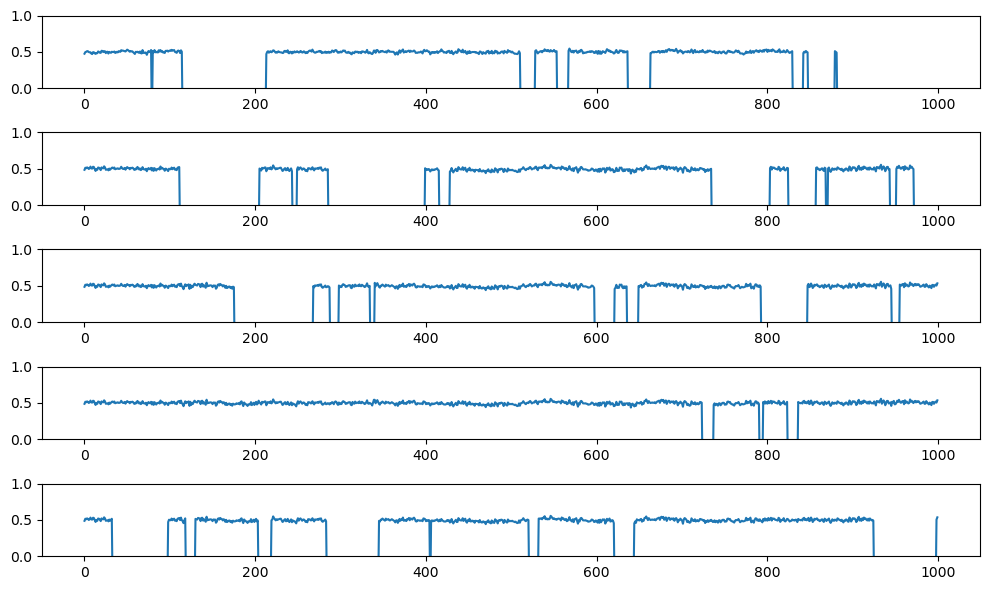

In [4]:
# Create a figure with two subplots (panels)
fig, axs = plt.subplots(5, 1, figsize=(10, 6))
for i in range(5):
    axs[i].plot(training_data[i] )
    axs[i].set_ylim([0,1])
plt.tight_layout()
plt.show()


In [5]:
# Define the generator model
"""def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(100,)),
        #tf.keras.layers.Dense(128, activation='relu', input_shape=(100,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(5)  # Output: [num_points, frequency, amplitude]
    ])
    return model """
def make_generator_model():
    noise_input = tf.keras.layers.Input(shape=(100,))
    x = tf.keras.layers.Dense(128, activation='relu')(noise_input)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer without activation
    raw_output = tf.keras.layers.Dense(5)(x)
    
    # Apply appropriate activations/scaling to each output
    To = tf.keras.layers.Lambda(lambda x: tf.abs(x) + 0.1)(raw_output[:, 0:1])  # Positive, non-zero
    Tc = tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 0.1)(raw_output[:, 1:2])  # Positive, non-zero
    phase = tf.keras.layers.Lambda(lambda x: x * 2 * np.pi)(raw_output[:, 2:3])  # Any value, scaled to [0, 2π]
    Anoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 3:4])  # Positive
    Fnoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 4:5])  # Positive
    
    output = tf.keras.layers.Concatenate()([To, Tc, phase, Anoise, Fnoise])
    
    return tf.keras.Model(inputs=noise_input, outputs=output)


# Define the discriminator model

def make_discriminator_model():
    inputs = tf.keras.Input(shape=(num_points,))
    
    # Reshape input to add channel dimension
    x = tf.keras.layers.Reshape((num_points, 1))(inputs)
    
    # 1D Convolutional layers
    x = tf.keras.layers.Conv1D(8, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(16, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Dropout(0.3) (x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    """
    # Dense layers
    x = tf.keras.layers.Dense(256, activation='leaky_relu')(x)
    x = tf.keras.layers.Dense(128, activation='leaky_relu')(x)"""
    
    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tf.print("real loss:", real_loss)
    tf.print("fake loss:", fake_loss)
    return real_loss + fake_loss

def generator_loss(fake_output):
    tf.print("fake_output data IN GEN LOSS :", fake_output[:5])
    CE = cross_entropy(tf.ones_like(fake_output), fake_output)
    tf.print("Cross Entropy shape:", tf.shape(CE))
    tf.print("GEN Cross Entropy:", CE)
    return CE

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)



In [7]:
# Training step
@tf.function
def train_step(real_data):
    #tf.print("Real data shape:", tf.shape(real_data))
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_params = generator(noise, training=True)      
        generated_data = tf.map_fn(sim_channel, generated_params, fn_output_signature=tf.float32)
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    steps_per_epoch = math.floor(num_samples / batch_size)
    
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Initialize loss accumulators for each epoch
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        
        for step, batch in tqdm(enumerate(dataset), total=steps_per_epoch):
            if step >= steps_per_epoch:
                break  # Move to the next epoch          
            try:
                gen_loss, disc_loss = train_step(batch)
                epoch_gen_loss += gen_loss
                epoch_disc_loss += disc_loss
            except Exception as e:
                print(f"Error during training: {e}")
                break
        
        # Calculate average losses for the epoch
        avg_gen_loss = epoch_gen_loss / steps_per_epoch
        avg_disc_loss = epoch_disc_loss / steps_per_epoch
        #clear_output(wait=True)
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Generator Loss: {avg_gen_loss:.8f}, "
              f"Discriminator Loss: {avg_disc_loss:.8f}")
        
        # Generate and plot sine waves
        egs=5
        
        # Generate and plot sine waves
        EgNoise = tf.random.normal([egs, 100])
        #print("EgNoise", EgNoise[0])
        generated_params = generator(EgNoise, training=False)
        print(steps_per_epoch)
        print("params", generated_params[0])
       
        gen_waves=[]
        for i in range(egs):
            gen_waves.append( sim_channel(generated_params[i]) )
        
        # Create a figure with two subplots (panels)
        fig, axs = plt.subplots(egs, 1, figsize=(10, 6))
        for i in range(egs):
            axs[i].plot(gen_waves[i] )
            #axs[i].set_ylim([0,1])
        plt.tight_layout()
        plt.show()
              
        if (epoch + 1) % 10 == 0:
            print(f"Completed {epoch + 1} epochs")
            plt.savefig(f"chanFigs/fig{epoch}.png")


In [8]:
batch_size = 10
training_dataset = tf.data.Dataset.from_tensor_slices(
    training_data).shuffle(num_samples).batch(batch_size, drop_remainder=True).repeat()


In [30]:
tf.print(tf.shape(training_data))


[1000 1000]


In [31]:
epochs=20
train(training_dataset, epochs)

Epoch 1/20


  0%|                                                                                                  | 0/100 [00:00<?, ?it/s]

fake_output data IN GEN LOSS : [[-0.021332331]
 [-0.021984769]
 [-0.0355301425]
 [-0.0125779789]
 [-0.0329497643]]
Cross Entropy shape: []
GEN Cross Entropy: 0.700429797
real loss: 0.703237414
fake loss: 0.685956299


  0%|                                                                                                  | 0/100 [00:00<?, ?it/s]

Error during training: No gradients provided for any variable.
Epoch 1/20 - Generator Loss: 0.00000000, Discriminator Loss: 0.00000000


In [ ]:
num_samples=1000